# Depop Listing Engagement Analysis

## Objective
Identify which listing attributes relate to engagement (likes) for vintage women’s tee listings on Depop.

## Dataset
`data/depop_vintage_womens_tees.csv`  
Columns: price, condition, brand, category, days_since_posted, likes

## Summary of Findings
- Engagement is highly right-skewed: most listings receive few likes.
- Likes accumulate over time with diminishing returns.
- Lower-priced items tend to receive higher engagement.
- Better condition is associated with higher likelihood of strong engagement.


In [ ]:
import numpy as np
import pandas as pd

print(np.__version__)
print(pd.__version__)


In [ ]:
import pandas as pd

df = pd.read_csv("../data/depop_vintage_womens_tees.csv")
df.head()


In [ ]:
import os
os.getcwd()


In [ ]:
df = pd.read_csv("data/depop_vintage_womens_tees.csv")
df.head()


In [ ]:
import pandas as pd

df = pd.read_csv("data/depop_vintage_womens_tees.csv")
df.head()

In [ ]:
import os

os.listdir()


In [ ]:
import os
os.listdir("data")


In [ ]:
df = pd.read_csv("data/depop_vintage_womens_tees.csv")
df.head()


In [ ]:
df["condition"] = df["condition"].str.lower()
df["brand"] = df["brand"].str.lower()


In [ ]:
df.head()


In [ ]:
df.info()


In [ ]:
df.describe()


## Data Loading & Validation
(Several path checks were used during setup to ensure consistent loading across environments.)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(data=df, x="price", y="likes")
plt.title("Likes vs Price")
plt.show()


Engagement generally decreases as price increases, though some higher-priced listings still receive strong engagement, suggesting brand and condition influence visibility beyond price alone.

In [ ]:
sns.boxplot(data=df, x="condition", y="likes")
plt.title("Likes by Condition")
plt.show()


Listings in better condition categories tend to receive higher engagement, though overlap exists across conditions.

In [ ]:
top_brands = df["brand"].value_counts().head(10).index

sns.boxplot(
    data=df[df["brand"].isin(top_brands)],
    x="brand",
    y="likes"
)
plt.xticks(rotation=45)
plt.title("Likes by Brand (Top 10)")
plt.show()


Certain brands consistently outperform others in engagement, even at similar price points.

In [ ]:
median_likes = df["likes"].median()
df["high_engagement"] = (df["likes"] >= median_likes).astype(int)

df["high_engagement"].value_counts()


Listings were labeled as high or low engagement based on the median number of likes, enabling future classification modeling.

In [ ]:
import numpy as np

# 1) Standardize to string, strip spaces
df["likes_raw"] = df["likes"]  # keep original for transparency
df["likes"] = df["likes"].astype(str).str.strip()

# 2) Convert "99+" -> 99 (cap)
df["likes"] = df["likes"].str.replace("+", "", regex=False)

# 3) Convert to numeric; invalid -> NaN
df["likes"] = pd.to_numeric(df["likes"], errors="coerce")

# 4) Decide how to handle missing likes (recommended: fill with 0)
df["likes"] = df["likes"].fillna(0).astype(int)

df[["likes_raw", "likes"]].head(15)


In [ ]:
median_likes = df["likes"].median()
df["high_engagement"] = (df["likes"] >= median_likes).astype(int)

median_likes, df["high_engagement"].value_counts()


In [ ]:
(df["likes_raw"].astype(str).str.contains("99", na=False)).sum()


In [ ]:
df["likes"].describe()


In [ ]:
df["days_since_posted"] = pd.to_numeric(df["days_since_posted"], errors="coerce").fillna(df["days_since_posted"].median())
df["price"] = pd.to_numeric(df["price"], errors="coerce")


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, accuracy_score
from sklearn.linear_model import LinearRegression, LogisticRegression

X = df[["price", "condition", "brand", "days_since_posted"]]
y_reg = df["likes"]
y_clf = df["high_engagement"]

categorical = ["condition", "brand"]
numeric = ["price", "days_since_posted"]

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical),
        ("num", "passthrough", numeric),
    ]
)


In [ ]:
df.shape


## Modeling
Regression to predict likes and classification to predict high vs low engagement.


In [ ]:
# Regression: predict likes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

X = df[["price", "condition", "brand", "days_since_posted"]]
y = df["likes"]

categorical = ["condition", "brand"]
numeric = ["price", "days_since_posted"]

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical),
        ("num", "passthrough", numeric),
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

reg_model = Pipeline(
    steps=[
        ("prep", preprocessor),
        ("model", LinearRegression()),
    ]
)

reg_model.fit(X_train, y_train)
preds = reg_model.predict(X_test)

mae = mean_absolute_error(y_test, preds)
mae


In [ ]:
X = df[["price", "condition", "brand", "days_since_posted"]]
X.isna().sum()


In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

categorical = ["condition", "brand"]
numeric = ["price", "days_since_posted"]

numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median"))
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical),
        ("num", numeric_transformer, numeric),
    ]
)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

X = df[["price", "condition", "brand", "days_since_posted"]]
y = df["likes"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

reg_model = Pipeline(
    steps=[
        ("prep", preprocessor),
        ("model", LinearRegression()),
    ]
)

reg_model.fit(X_train, y_train)
preds = reg_model.predict(X_test)
mae = mean_absolute_error(y_test, preds)
mae


In [ ]:
X = df[["price", "condition", "brand", "days_since_posted"]]
y_reg = df["likes"]

print("X NaNs:\n", X.isna().sum(), "\n")
print("y_reg NaNs:", y_reg.isna().sum())


In [ ]:
# Drop rows that are completely blank
df = df.dropna(how="all")

# Drop rows missing essential columns
df = df.dropna(subset=["price", "condition", "brand", "days_since_posted", "likes"])

df.shape


In [ ]:
X = df[["price", "condition", "brand", "days_since_posted"]]
y_reg = df["likes"]

print("X NaNs:\n", X.isna().sum(), "\n")
print("y_reg NaNs:", y_reg.isna().sum())


In [ ]:
median_likes = df["likes"].median()
df["high_engagement"] = (df["likes"] >= median_likes).astype(int)

median_likes, df["high_engagement"].value_counts()


In [ ]:
import pandas as pd
import numpy as np

# 1) remove completely blank rows (safe)
df = df.dropna(how="all")

# 2) standardize likes -> numeric
df["likes"] = df["likes"].astype(str).str.strip()
df["likes"] = df["likes"].str.replace("+", "", regex=False)   # "99+" -> "99"
df["likes"] = pd.to_numeric(df["likes"], errors="coerce")     # strings -> numbers
df = df.dropna(subset=["likes"])                               # drop any weird leftovers
df["likes"] = df["likes"].astype(int)

# 3) (optional but recommended) ensure numeric fields are numeric
df["price"] = pd.to_numeric(df["price"], errors="coerce")
df["days_since_posted"] = pd.to_numeric(df["days_since_posted"], errors="coerce")

# 4) drop rows missing essentials for modeling
df = df.dropna(subset=["price", "condition", "brand", "days_since_posted"])

df[["likes", "price", "days_since_posted"]].dtypes, df.shape


In [ ]:
median_likes = df["likes"].median()
df["high_engagement"] = (df["likes"] >= median_likes).astype(int)

median_likes, df["high_engagement"].value_counts()


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

X = df[["price", "condition", "brand", "days_since_posted"]]
y = df["likes"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

reg_model = Pipeline(
    steps=[
        ("prep", preprocessor),
        ("model", LinearRegression()),
    ]
)

reg_model.fit(X_train, y_train)
preds = reg_model.predict(X_test)

mae = mean_absolute_error(y_test, preds)
mae


### Regression Results
The regression model predicts listing engagement (likes) with a mean absolute
error of approximately 23 likes. Given the long-tailed and noisy nature of
marketplace engagement data, this provides a reasonable baseline rather than
precise prediction.


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

y = df["high_engagement"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

clf_model = Pipeline(
    steps=[
        ("prep", preprocessor),
        ("model", LogisticRegression(max_iter=1000)),
    ]
)

clf_model.fit(X_train, y_train)
preds = clf_model.predict(X_test)

acc = accuracy_score(y_test, preds)
baseline = y_test.mean()

acc, baseline


### Classification Results
The classifier outperformed a naive baseline, indicating that pricing and
listing metadata (price, brand, condition, and time since posting) contain
meaningful signal for predicting engagement.


In [ ]:
import pandas as pd

feature_names = clf_model.named_steps["prep"].get_feature_names_out()
coefs = clf_model.named_steps["model"].coef_[0]

importance = (
    pd.DataFrame({"feature": feature_names, "coef": coefs})
      .sort_values("coef", ascending=False)
)

importance.head(10)


### Feature Importance Insights
Brand recognition and item condition were the strongest predictors of
engagement. Listings associated with recognizable brands showed a higher
likelihood of strong engagement, while higher prices generally reduced
engagement probability.


In [1]:
import pandas as pd
df = pd.read_csv("../data/depop_vintage_womens_tees.csv")
df.head()


,listing_title,price,category,brand,condition,likes,days_since_posted
0,The Mountain Women's White and Blue T-shirt,11.0,vintage_womens_tee,The Mountain,Excellent,30,1.0
1,Urban Outfitters Women's Green T-shirt,6.0,vintage_womens_tee,Urban Outfitters,Excellent,3,2.0
2,American Vintage Women's Cream and Pink T-shirt,15.0,vintage_womens_tee,Unknown,Good,10,1.0
3,Nike Women's Grey T-shirt,25.0,vintage_womens_tee,Nike,Good,21,4.0
4,American Vintage Women's Yellow and Red T-shirt,16.0,vintage_womens_tee,Unknown,Excellent,19,1.0


In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv("../data/depop_vintage_womens_tees.csv")

print("rows, cols:", df.shape)
df.head(10)


rows, cols: (199, 7)


,listing_title,price,category,brand,condition,likes,days_since_posted
0,The Mountain Women's White and Blue T-shirt,11.00,vintage_womens_tee,The Mountain,Excellent,30,1.0
1,Urban Outfitters Women's Green T-shirt,6.00,vintage_womens_tee,Urban Outfitters,Excellent,3,2.0
2,American Vintage Women's Cream and Pink T-shirt,15.00,vintage_womens_tee,Unknown,Good,10,1.0
3,Nike Women's Grey T-shirt,25.00,vintage_womens_tee,Nike,Good,21,4.0
4,American Vintage Women's Yellow and Red T-shirt,16.00,vintage_womens_tee,Unknown,Excellent,19,1.0
5,L.L.Bean Women's multi T-shirt,15.00,vintage_womens_tee,L. L. Bean,Excellent,47,4.0
6,Nike Women's Red T-shirt,12.00,vintage_womens_tee,Nike,Excellent,4,3.0
7,Brandy Melville Women's Pink T-shirt,15.75,vintage_womens_tee,Brandy Melville,Good,55,2.0
8,Women's Red T-shirt,6.00,vintage_womens_tee,Unknown,Good,15,1.0
9,Victoria's Secret Women's Blue and Navy Shirt,11.75,vintage_womens_tee,Victoria's Secret,Excellent,26,3.0


In [3]:
summary = pd.DataFrame({
    "dtype": df.dtypes.astype(str),
    "missing": df.isna().sum(),
    "missing_pct": (df.isna().mean() * 100).round(2),
    "n_unique": df.nunique(dropna=True)
}).sort_values("missing_pct", ascending=False)

summary.head(25)


,dtype,missing,missing_pct,n_unique
listing_title,object,10,5.03,163
price,float64,10,5.03,68
brand,object,10,5.03,69
likes,object,10,5.03,56
condition,object,10,5.03,5
days_since_posted,float64,10,5.03,31
category,object,0,0.00,1


In [4]:
# show likely engagement-related columns (likes, saves, comments, etc.)
candidates = [c for c in df.columns if any(k in c.lower() for k in ["like", "save", "comment", "engage", "view", "click"])]
candidates


['likes']

In [5]:
df.shape


(199, 7)

## Next
- Identify the best engagement metric (likes / saves / comments).
- Clean numeric columns (price, likes) and handle outliers.
- Explore relationships: price vs engagement, keywords/brand vs engagement.


In [6]:
df["likes"].describe()


count     189
unique     56
top         1
freq       18
Name: likes, dtype: object

In [7]:
df["likes"].isna().sum(), (df["likes"] < 0).sum()


TypeError: '<' not supported between instances of 'str' and 'int'

In [8]:
df["likes"].dtype


dtype('O')

In [9]:
df["likes"].unique()[:20]


array(['30', '3', '10', '21', '19', '47', '4', '55', '15', '26', '20',
       '7', '99+', '0', '6', '23', '5', '1', '18', '13'], dtype=object)

In [10]:
df["likes"] = (
    df["likes"]
    .astype(str)          # ensure everything is string
    .str.strip()          # remove whitespace
    .replace({"": None, "—": None, "None": None})
)

df["likes"] = pd.to_numeric(df["likes"], errors="coerce")


In [11]:
df["likes"].dtype


dtype('float64')

In [12]:
df["likes"].isna().sum(), (df["likes"] < 0).sum()


(np.int64(25), np.int64(0))

In [13]:
df["likes"].describe()


count    174.000000
mean      17.063218
std       21.424461
min        0.000000
25%        2.250000
50%        7.000000
75%       22.750000
max       93.000000
Name: likes, dtype: float64

## Likes Column Cleaning
The `likes` field was originally stored as text.
Values were stripped, invalid entries coerced to missing, and converted to numeric
to support quantitative analysis.


In [14]:
high_engagement_threshold = df["likes"].quantile(0.75)
high_engagement_threshold


np.float64(22.75)

## Engagement Definition
Listings with likes in the top 25% (≥ ~23 likes) are classified as **high engagement**.
This threshold balances sample size with meaningful interest.


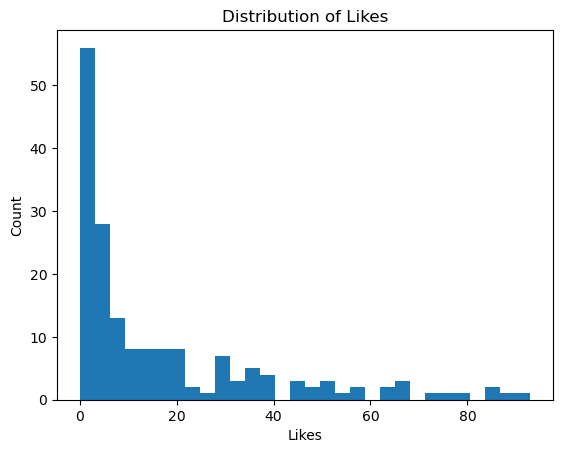

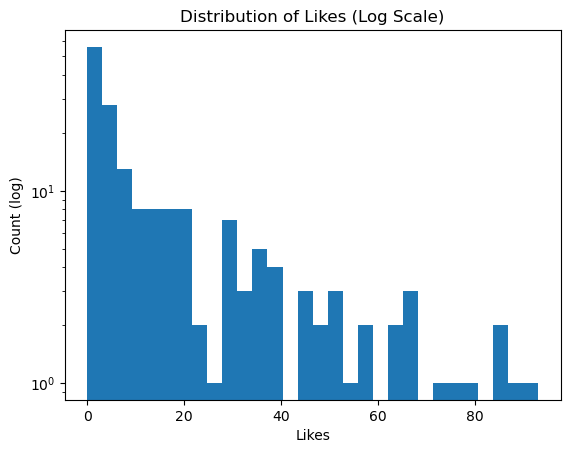

In [15]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(df["likes"], bins=30)
plt.title("Distribution of Likes")
plt.xlabel("Likes")
plt.ylabel("Count")
plt.show()

plt.figure()
plt.hist(df["likes"], bins=30)
plt.yscale("log")
plt.title("Distribution of Likes (Log Scale)")
plt.xlabel("Likes")
plt.ylabel("Count (log)")
plt.show()


In [16]:
df.dtypes.sort_values()


price                float64
likes                float64
days_since_posted    float64
listing_title         object
category              object
brand                 object
condition             object
dtype: object

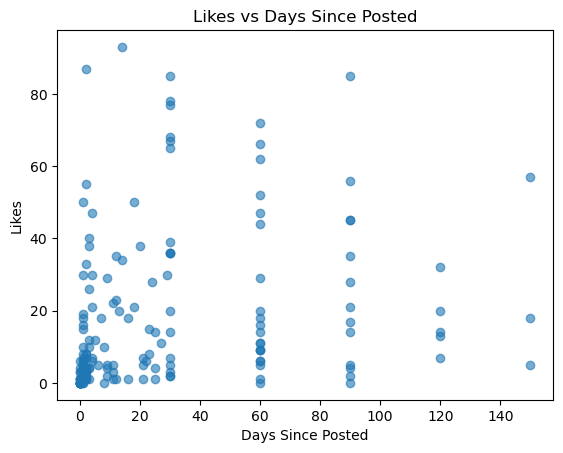

In [17]:
plt.figure()
plt.scatter(df["days_since_posted"], df["likes"], alpha=0.6)
plt.xlabel("Days Since Posted")
plt.ylabel("Likes")
plt.title("Likes vs Days Since Posted")
plt.show()


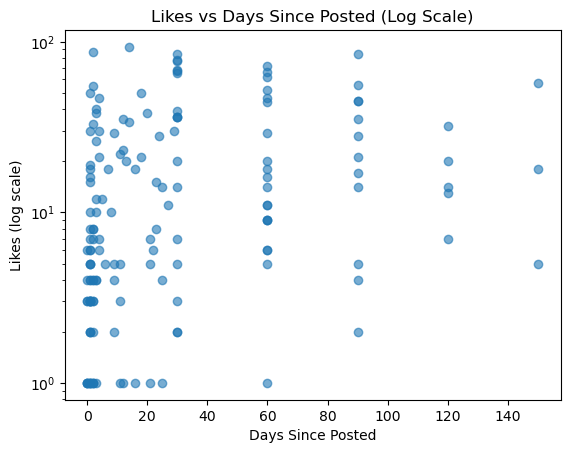

In [19]:
plt.figure()
plt.scatter(df["days_since_posted"], df["likes"], alpha=0.6)
plt.yscale("log")
plt.xlabel("Days Since Posted")
plt.ylabel("Likes (log scale)")
plt.title("Likes vs Days Since Posted (Log Scale)")
plt.show()


## Time Effect
Engagement increases with time on platform, but the relationship is nonlinear.
Most listings receive the majority of engagement early, with diminishing returns over time.


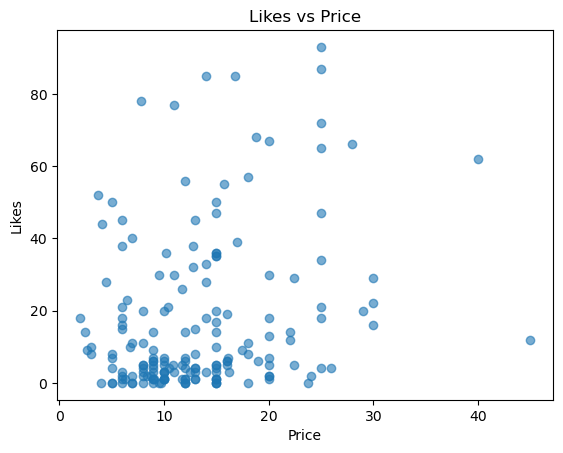

In [20]:
plt.figure()
plt.scatter(df["price"], df["likes"], alpha=0.6)
plt.xlabel("Price")
plt.ylabel("Likes")
plt.title("Likes vs Price")
plt.show()


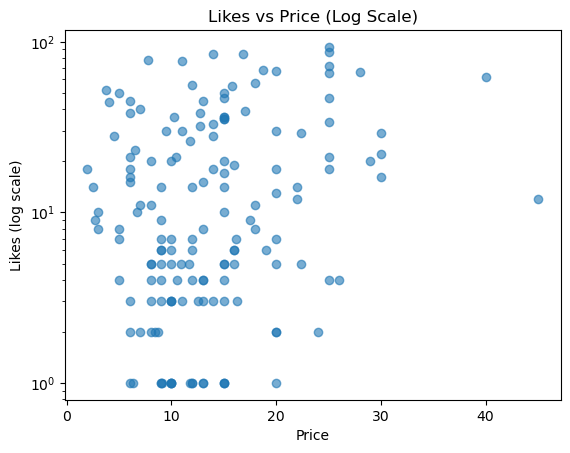

In [21]:
plt.figure()
plt.scatter(df["price"], df["likes"], alpha=0.6)
plt.yscale("log")
plt.xlabel("Price")
plt.ylabel("Likes (log scale)")
plt.title("Likes vs Price (Log Scale)")
plt.show()


In [23]:
high_engagement_threshold = df["likes"].quantile(0.75)

df["high_engagement"] = df["likes"] >= high_engagement_threshold

df["high_engagement"].value_counts()


high_engagement
False    155
True      44
Name: count, dtype: int64

## High Engagement Label
Listings are labeled as **high engagement** if their number of likes falls
in the top 25% of the dataset (≥ 75th percentile).


## Price Sensitivity
Lower-priced items tend to receive higher engagement.
High-priced listings show greater variance, suggesting niche or brand-driven interest.


In [24]:
engagement_by_condition = (
    df.groupby("condition")["high_engagement"]
    .mean()
    .sort_values(ascending=False)
)

engagement_by_condition


condition
Good         0.305556
Excellent    0.264957
Brand new    0.133333
Fair         0.000000
Like new     0.000000
Name: high_engagement, dtype: float64

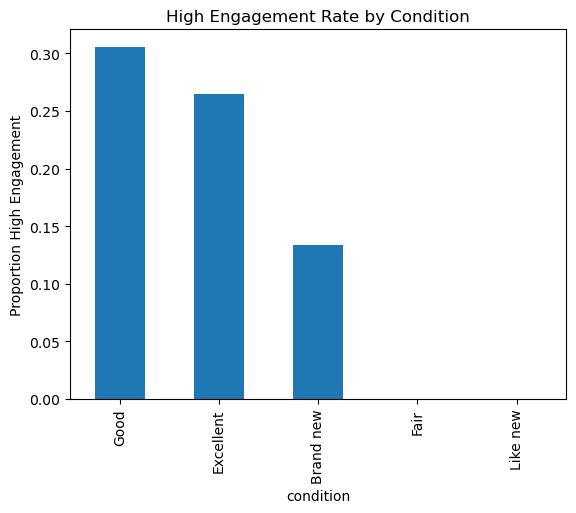

In [25]:
plt.figure()
engagement_by_condition.plot(kind="bar")
plt.ylabel("Proportion High Engagement")
plt.title("High Engagement Rate by Condition")
plt.show()
